# Project 02 - Due Friday, November 11 at 12pm

*Objectives*: Gain experience loading a transactional dataset into a relational database model you define yourself and using SQL to explore its contents. Transform the data into a star schema, documenting the schema visually, and explore the transformed data analytically by writing and executing a number of SQL queries using common syntax and functions and describing your findings.  Gain practice working on these tasks with a partner.

*Grading criteria*: The tasks should all be completed, and questions should all be answered with SQL queries, diagrams, and charts in the space provided, unless a text answer is requested.  The notebook itself should be completely reproducible at datanotebook.org, from start to finish: another person should be able to use the same code to obtain the same results as yours.  Note that you will receive no more than partial credit if you do not add text/markdown cells explaining your thinking at each major step in each problem.

*Attestation*: **Work in pairs**.  At the end of your submitted notebook, identify the work each partner performed and attest that each contributed substantially to the work.

*Deadline*: Friday, November 11, 12pm.  One member of each pair must submit your notebook to Blackboard; you should not both submit it separately.  You may each push a copy to your own GitHub repository.


## Setup - select and obtain data

The US City Open Data Census has a variety of [transactional data from all over the country](http://us-city.census.okfn.org/).  Select one topic and one city from this Census, download the data, and explain your reason for this choice before proceeding.  Provide a link to the web page for the data set you've chosen.

I strongly encourage you to select a dataset from among the following topics:  Crime, Property Assessment, Campaign Finance Contributions, Service Requests (311), and Web Analytics.

By *transactional* data I mean records at the grain of one event per business process.  In the case of Service Requests (311), for example, that would require data at the level of each individual report of a service request.  If this isn't clear, think about the bike trip data - each individual ride was included - and look for data at that level of event/process specificity.  Avoid data like the Connecticut boating data, which was summarized by year, not individual transactions.

Please aim for a dataset of at least 10,000 individual records, but less than 250,000 records.  A little more or a little less is okay, but try to stay within these limits.

# Choose the dataset
We choose to analyze the crime data of New York City. You can also access the dataset via:http://us-city.census.okfn.org/entry/newyorkcity/crime-stats. This dataset is being updated quarterly and is available at the incident level. The data set contains open crime data that helps communities make informed judgements about public safety.

Firstly, we download the dataset, rename the dataset and transfer into csv look:

In [1]:
!wget https://data.cityofnewyork.us/api/views/hyij-8hr7/rows.csv?accessType=DOWNLOAD

--2016-11-10 18:26:38--  https://data.cityofnewyork.us/api/views/hyij-8hr7/rows.csv?accessType=DOWNLOAD
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [     <=>              ] 185.12M  2.11MB/s   in 96s    

Last-modified header invalid -- time-stamp ignored.
2016-11-10 18:28:14 (1.93 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [194111037]



## Problem 1 - examine the data (20 points)

Use `csvstat`, `pandas`, or other tools as you see fit and observe the contents of your dataset.  Review important points from any metadata provided.  Describe what you see:  What do the columns mean?  Are there null values?  Which columns interest you the most?  Which columns present some opportunities, challenges, or questions you would like to ask?

In [2]:
!mv rows.csv?accessType=DOWNLOAD crime.csv

In [3]:
!csvcut crime.csv | head -10 | csvlook

|-----------+------------+------------------------+-------------+------------------+----------------+-----------------+-----------------+----------------+--------------+---------------+--------------------------------+------------------------+--------+----------+-----------+---------------------+-------------+-------------+----------------------------------------|
|  OBJECTID | Identifier | Occurrence Date        | Day of Week | Occurrence Month | Occurrence Day | Occurrence Year | Occurrence Hour | CompStat Month | CompStat Day | CompStat Year | Offense                        | Offense Classification | Sector | Precinct | Borough   | Jurisdiction        | XCoordinate | YCoordinate | Location 1                             |
|-----------+------------+------------------------+-------------+------------------+----------------+-----------------+-----------------+----------------+--------------+---------------+--------------------------------+------------------------+--------+----------+---

In [4]:
!wc -l crime.csv

1123466 crime.csv


Since the dataset is huge, we decide only to work on the subset of rape offense. Therefore, we extract the data about rape offense.

In [5]:
!csvcut crime.csv | csvgrep -c12 -m 'RAPE' > rape.csv

In [6]:
!csvcut -n rape.csv 

  1: OBJECTID
  2: Identifier
  3: Occurrence Date
  4: Day of Week
  5: Occurrence Month
  6: Occurrence Day
  7: Occurrence Year
  8: Occurrence Hour
  9: CompStat Month
 10: CompStat Day
 11: CompStat Year
 12: Offense
 13: Offense Classification
 14: Sector
 15: Precinct
 16: Borough
 17: Jurisdiction
 18: XCoordinate
 19: YCoordinate
 20: Location 1


In [7]:
!wc -l rape.csv

13780 rape.csv


Initially, there is 20 columns, but we are not gonna use all of them. We extract the columns that we are interested in -- Colums that shows the time and the location of rape offenses. The reason that we are interested in these information is because we can use these 2 dimension to describe: in which place, during which time period, are rape offenses likely to happen.
Then we transer the subset into csvlook.

In [8]:
!csvcut -c3,4,5,6,7,8,12,14,15,16,17,18,19 rape.csv > rape_final.csv

In [9]:
!csvcut rape_final.csv | head | csvlook

|-------------------------+-------------+------------------+----------------+-----------------+-----------------+---------+--------+----------+-----------+---------------------+-------------+--------------|
|  Occurrence Date        | Day of Week | Occurrence Month | Occurrence Day | Occurrence Year | Occurrence Hour | Offense | Sector | Precinct | Borough   | Jurisdiction        | XCoordinate | YCoordinate  |
|-------------------------+-------------+------------------+----------------+-----------------+-----------------+---------+--------+----------+-----------+---------------------+-------------+--------------|
|  08/08/1994 06:00:00 PM | Monday      | Aug              | 8              | 1994            | 18              | RAPE    | A      | 103      | QUEENS    | N.Y. POLICE DEPT    | 1041749     | 196938       |
|  02/01/1995 08:00:00 AM | Wednesday   | Feb              | 1              | 1995            | 8               | RAPE    | G      | 83       | BROOKLYN  | N.Y. POLICE DEPT

In [14]:
!wc -l rape_final.csv

13780 rape_final.csv


In [15]:
!csvcut -n rape_final.csv

  1: Occurrence Date
  2: Day of Week
  3: Occurrence Month
  4: Occurrence Day
  5: Occurrence Year
  6: Occurrence Hour
  7: Offense
  8: Sector
  9: Precinct
 10: Borough
 11: Jurisdiction
 12: XCoordinate
 13: YCoordinate


Finally, we have a dataset that we want to work with: 13780 observations and 13 columns. Them we will keep exploring these data.

In [10]:
%load_ext sql

/opt/conda/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [11]:
!echo 'redspot' | sudo -S service postgresql restart

[sudo] password for jovyan: Restarting PostgreSQL 9.5 database server: main.


In [12]:
!createdb -U dbuser Project2

In [13]:
%sql postgresql://dbuser@localhost:5432/Project2

'Connected: dbuser@Project2'

In [16]:
!csvstat rape_final.csv

  1. Occurrence Date
	<class 'datetime.datetime'>
	Nulls: True
	Min: 1975-01-01 00:01:00
	Max: 2015-12-30 18:00:00
	Unique values: 12558
	5 most frequent values:
		2005-01-01 00:01:00:	23
		2007-01-01 00:01:00:	22
		2008-01-01 00:01:00:	20
		2010-01-01 00:01:00:	18
		2006-01-01 00:01:00:	18
  2. Day of Week
	<class 'str'>
	Nulls: True
	Unique values: 7
	5 most frequent values:
		Saturday:	2312
		Sunday:	2255
		Friday:	2067
		Monday:	1831
		Thursday:	1776
	Max length: 9
  3. Occurrence Month
	<class 'str'>
	Nulls: True
	Unique values: 12
	5 most frequent values:
		Jan:	1414
		Jul:	1299
		Aug:	1268
		Jun:	1266
		Oct:	1166
	Max length: 4
  4. Occurrence Day
	<class 'int'>
	Nulls: True
	Min: 1
	Max: 31
	Sum: 190088
	Mean: 13.79648715343301
	Median: 14.0
	Standard Deviation: 9.558368831423818
	Unique values: 31
	5 most frequent values:
		1:	2178
		15:	504
		20:	429
		10:	428
		25:	424
  5. Occurrence Year
	<class 'int'>
	Nulls: True
	Min: 1975
	Max: 2015
	Sum: 27688816
	Mean: 2009.931475029

In this dataset, there are null values in some colums:

1.Occurrence Date

2.Day of Week

3.Occurrence Month

4.Occurrence Day

5.Occurrence Year

6.Occurrence Hour

7.Sector

We are using these data to answer following questions?

1. Where in NYC is the rape most likely to happen?
2. When is the rape most likely to happen?

## Problem 2 - define a database model, load the data, and explore (20 points)

Based on what you found above, create and connect to a new database, define a database table in it, and load this dataset into it.  You may use either of the methods for this step you have seen in earlier class notebooks.  You may choose to eliminate variables/columns if they are not relevant or interesting to you - explain your reasoning if you do.  Either way, you should load a majority of the columns present in the source dataset as it is in its raw form into the database, and all of its rows.

Once your data has loaded successfully, run a `COUNT(*)` query to verify that all the data has loaded correctly.

Explore the data to zero in on a few themes you would like to further study analytically.  Discuss columns that present opportunities for extraction into dimensions, and identify the specific columns that contain facts you want to measure.

Now we create table and load all the data.

In [17]:
%%sql
DROP TABLE IF EXISTS rapecrimes;
CREATE TABLE rapecrimes (
    date TIMESTAMP,
    day CHAR(9),
    month CHAR(4),
    day_n INT,
    year INT,
    hour CHAR(5),
    offense CHAR(5),
    sector CHAR(4),
    precint INT,
    borough CHAR(19),
    jur char(19),
    xcor BIGINT,
    ycor BIGINT
    )



Done.
Done.


[]

In [18]:
%%sql
COPY rapecrimes FROM '/home/jovyan/work/rape_final.csv'
CSV
HEADER
QUOTE '"'
DELIMITER ',';

13779 rows affected.


[]

In [19]:
%%sql
select * from rapecrimes
LIMIT 10;

10 rows affected.


date,day,month,day_n,year,hour,offense,sector,precint,borough,jur,xcor,ycor
1994-08-08 18:00:00,Monday,Aug,8,1994,18,RAPE,A,103,QUEENS,N.Y. POLICE DEPT,1041749,196938
1995-02-01 08:00:00,Wednesday,Feb,1,1995,8,RAPE,G,83,BROOKLYN,N.Y. POLICE DEPT,1006965,193571
2000-01-09 20:00:00,Sunday,Jan,9,2000,20,RAPE,G,108,QUEENS,N.Y. POLICE DEPT,996793,210001
2001-01-09 15:00:00,Tuesday,Jan,9,2001,15,RAPE,H,63,BROOKLYN,N.Y. HOUSING POLICE,1000448,168068
2001-02-11 00:01:00,Sunday,Feb,11,2001,0,RAPE,B,25,MANHATTAN,N.Y. POLICE DEPT,1000555,230994
2001-11-19 12:00:00,Monday,Nov,19,2001,12,RAPE,G,75,BROOKLYN,N.Y. POLICE DEPT,1017141,183798
2002-07-25 12:00:00,Thursday,Jul,25,2002,12,RAPE,A,101,QUEENS,N.Y. POLICE DEPT,1053678,159044
2002-07-30 12:00:00,Tuesday,Jul,30,2002,12,RAPE,E,47,BRONX,N.Y. POLICE DEPT,1026387,262634
2002-10-15 07:00:00,Tuesday,Oct,15,2002,7,RAPE,C,79,BROOKLYN,N.Y. POLICE DEPT,999634,190253
2002-11-25 00:01:00,Monday,Nov,25,2002,0,RAPE,B,17,MANHATTAN,N.Y. POLICE DEPT,992411,215025


Now we will do some simple queries:

#### 1. In which years does the rape tend to happen most frequently?

In [26]:
%%sql
select year,count(*) from rapecrimes
GROUP BY year
ORDER BY count desc
LIMIT 5;

5 rows affected.


year,count
2006,1520
2011,1382
2012,1372
2010,1351
2013,1294


<Container object of 5 artists>

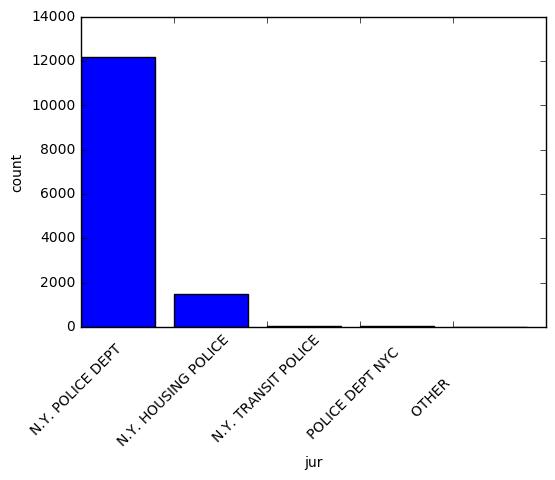

In [34]:
import matplotlib as plt
result = _
result.bar()

#### 2. In which day of the week does the rape tend to happen most frequently?

In [29]:
%%sql
SELECT day,count(*) FROM rapecrimes
GROUP BY day
ORDER BY count desc
LIMIT 5

5 rows affected.


day,count
Saturday,2312
Sunday,2255
Friday,2067
Monday,1831
Thursday,1776


#### 3. In which month does the rape tend to happen most frequently?

In [44]:
%%sql
SELECT month,count(*) FROM rapecrimes
GROUP BY month
ORDER BY count desc
LIMIT 5

5 rows affected.


month,count
Jan,1414
Jul,1299
Aug,1268
Jun,1266
Oct,1166


<Container object of 5 artists>

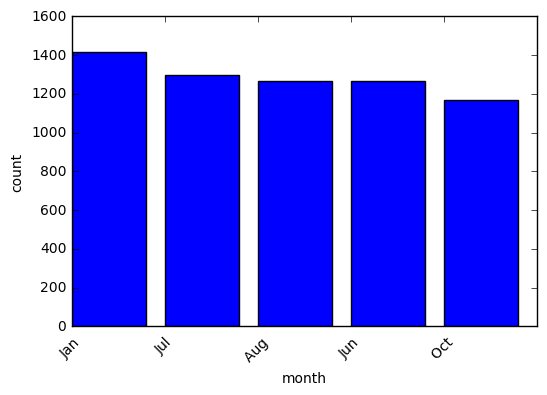

In [45]:
import matplotlib as plt
result = _
result.bar()

#### 4. In which area does the rape tend to happen most frequently?

In [41]:
%%sql
SELECT borough,count(*) FROM rapecrimes
GROUP BY borough
ORDER BY count desc
LIMIT 5

5 rows affected.


borough,count
BROOKLYN,4097
QUEENS,3182
BRONX,3018
MANHATTAN,2941
STATEN ISLAND,541


<Container object of 5 artists>

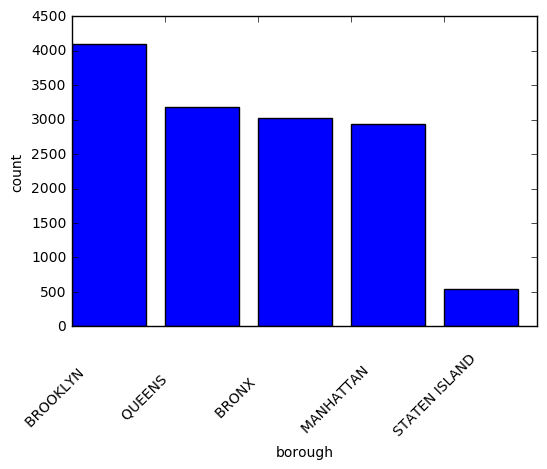

In [43]:
import matplotlib as plt
result = _
result.bar()

#### 5. In which jurisdiction does the rape tend to happen most frequently?

In [46]:
%%sql
SELECT jur,count(*) FROM rapecrimes
GROUP BY jur
ORDER BY count desc
LIMIT 5

5 rows affected.


jur,count
N.Y. POLICE DEPT,12183
N.Y. HOUSING POLICE,1497
N.Y. TRANSIT POLICE,34
POLICE DEPT NYC,16
OTHER,14


<Container object of 5 artists>

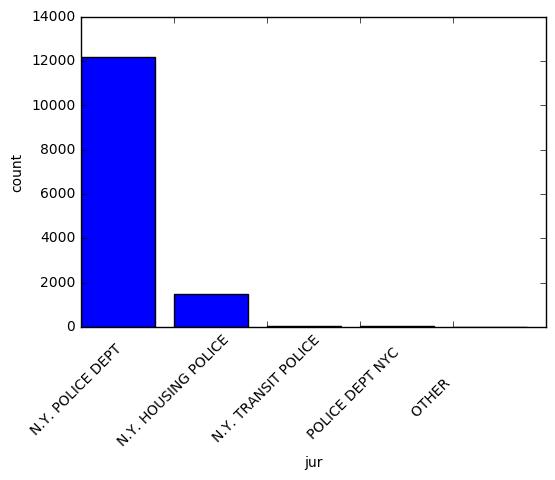

In [47]:
import matplotlib as plt
result = _
result.bar()

## Problem 3 - define a star schema, and load your data into it (30 points)

Define a star schema consisting of at least one fact table and at least two dimensions.  Transform your source data into the new fact table and dimensions.  Discuss your key modeling decisions.

Document your star schema with a diagram.  There several tools available for this, such as Google Docs and Microsoft Visio.

Here is how we design our star schema

ImportError: No module named 'image'

## Problem 4 - explore your data in its new schema (30 points)

Strictly using the dimensional model tables you defined and populated for Problem 3, explore your data in its new form.  Use any of the query strategies we've seen in class, including transformations, aggregates, subqueries, rollups, and, of course, joins.  Add plots to highlight particular themes that stand out.  Describe your thinking and observations along the way.

## Bonus (10 points for one of A or B)


### Option A - Automating ETL

Consider the work you did to load your original raw dataset and then transform it into a dimensional model for analysis.  What would it take to automate this process?  How often would you need to update the data?  Could you easily automate any data cleaning steps?  What checks would you need to put in place to ensure quality?  Would humans need to be involved, or could you automate it all?

Discuss.


### Option B - Augmenting dimensions

Considering your dimensional model, what external data could you find to augment it?  As in the case of bike trips, where weather might provide an interesting added dimension/context not present in the original data, you can probably find another source of data to complement your own model.  Identify one such source and add it to your model, demonstrating its value with a few new queries.